# Theory

- MultiQueryRetriever
- Contextual Compression
- Ensemble Retrievers
- Self-Querying Retrievers
- Time Weighted Vector Store Retrievers

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [50]:
# Import Packages
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.document_loaders import TextLoader
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter, LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever, BM25Retriever, EnsembleRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

## Chunksize Experiment

In [5]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

embedding = OpenAIEmbeddings(chunk_size=1)

In [6]:
loader = TextLoader("./dogs.txt")
data = loader.load()
loader = TextLoader("./restaurant.txt")
data2 = loader.load()

docs = data + data2

In [7]:
vector1 = embedding.embed_query("How is the whether??")
vector2 = embedding.embed_query("What is the Name of the Dogschool?")
vector3 = embedding.embed_query("What food do you offer?")

data_vectors = [embedding.embed_query(doc.page_content) for doc in docs]
print(len(data_vectors))

2


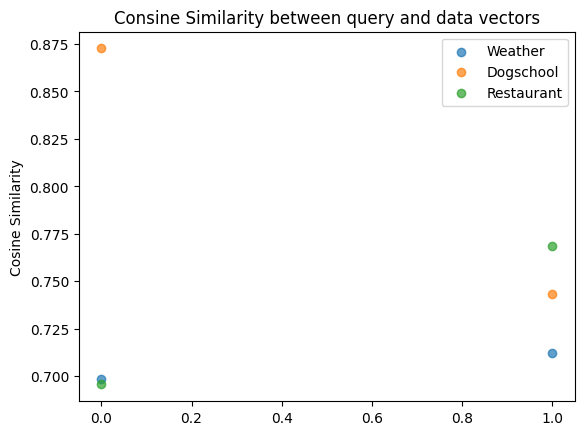

In [8]:
cosine_sims_1 = [cosine_similarity([vector1], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_2 = [cosine_similarity([vector2], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_3 = [cosine_similarity([vector3], [data_vector])[0][0] for data_vector in data_vectors]

x = np.arange(len(data_vectors))

plt.scatter(x, cosine_sims_1, label='Weather', alpha=0.7)
plt.scatter(x, cosine_sims_2, label='Dogschool', alpha=0.7)
plt.scatter(x, cosine_sims_3, label='Restaurant', alpha=0.7)

plt.ylabel('Cosine Similarity')
plt.title('Consine Similarity between query and data vectors')
plt.legend()

plt.show()

In [9]:
loader = TextLoader("./dogs.txt")
data = loader.load()
loader = TextLoader("./restaurant.txt")
data2 = loader.load()

docs = data + data2
text_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=10)
docs = text_splitter.split_documents(data)

In [10]:
vector1 = embedding.embed_query("How is the whether??")
vector2 = embedding.embed_query("What is the Name of the Dogschool?")
vector3 = embedding.embed_query("What food do you offer?")

data_vectors = [embedding.embed_query(doc.page_content) for doc in docs]
print(len(data_vectors))

19


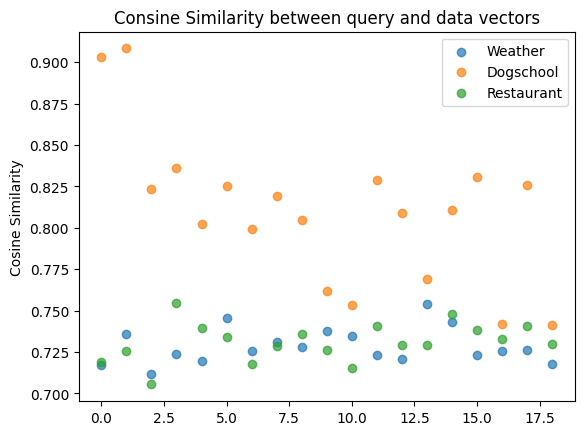

In [11]:
cosine_sims_1 = [cosine_similarity([vector1], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_2 = [cosine_similarity([vector2], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_3 = [cosine_similarity([vector3], [data_vector])[0][0] for data_vector in data_vectors]

x = np.arange(len(data_vectors))

plt.scatter(x, cosine_sims_1, label='Weather', alpha=0.7)
plt.scatter(x, cosine_sims_2, label='Dogschool', alpha=0.7)
plt.scatter(x, cosine_sims_3, label='Restaurant', alpha=0.7)

plt.ylabel('Cosine Similarity')
plt.title('Consine Similarity between query and data vectors')
plt.legend()

plt.show()

### Parent Child Retriever

In [12]:
# Create smaller chunks of data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=20)
# Create larger chunks of data
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=20)
# Create VectorStore
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

In [13]:
retriever.add_documents(docs, ids=None)

In [14]:
vectorstore.similarity_search("What is the name of the dog school?")

[Document(page_content='A1: The school is called "Canine Academy".', metadata={'doc_id': '58df10c1-a902-40c8-bd99-11d696899b9b', 'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'doc_id': '6347e665-3b27-4d2c-ac90-b3cc273fe9fd', 'source': './dogs.txt'}),
 Document(page_content='Q3: What training programs are offered at Canine Academy?', metadata={'doc_id': 'c96fb3d5-c3c5-4504-a907-6227f5446f83', 'source': './dogs.txt'}),
 Document(page_content='Q7: Does Canine Academy provide training for service or therapy dogs?', metadata={'doc_id': '218e187b-c687-44b5-a035-6c23666360c1', 'source': './dogs.txt'})]

In [15]:
retriever.get_relevant_documents("What is the name of the dog school?")

[Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q3: What training programs are offered at Canine Academy?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q7: Does Canine Academy provide training for service or therapy dogs?', metadata={'source': './dogs.txt'})]

### Another Example for Parent Document Retriever

In [16]:
sample_loaders = [
    TextLoader("paul_graham_essay.txt"),
    TextLoader("state_of_the_union.txt"),
]
sample_docs = []
for loader in sample_loaders:
    sample_docs.extend(loader.load())

#### Retrieving full documents

In [17]:
# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=OpenAIEmbeddings()
)
# The storage layer for the parent documents
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

In [18]:
retriever.add_documents(sample_docs, ids=None)

In [19]:
list(store.yield_keys())

['378e1404-9eec-4e29-9f46-da06c71193f3',
 '7f169cab-8b4a-41f6-be04-3b5b969a8369']

In [20]:
sub_docs = vectorstore.similarity_search("justice breyer")
print(sub_docs[0].page_content)

Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. 

One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court.


In [21]:
retrieved_docs = retriever.get_relevant_documents("justice breyer")
len(retrieved_docs[0].page_content)

38539

In [22]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="split_parents", embedding_function=OpenAIEmbeddings()
)
# The storage layer for the parent documents
store = InMemoryStore()

In [23]:
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [24]:
retriever.add_documents(sample_docs)

In [25]:
len(list(store.yield_keys()))

66

In [26]:
sub_docs = vectorstore.similarity_search("justice breyer")
print(sub_docs[0].page_content)

Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. 

One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court.


In [27]:
retrieved_docs = retriever.get_relevant_documents("justice breyer")
len(retrieved_docs[0].page_content)

1849

In [28]:
print(retrieved_docs[0].page_content)

In state after state, new laws have been passed, not only to suppress the vote, but to subvert entire elections. 

We cannot let this happen. 

Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights Act. And while you’re at it, pass the Disclose Act so Americans can know who is funding our elections. 

Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. 

One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. 

And I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence. 

A former top litigator in private practice. A former federal publi

## MultiQueryRetriever

- The MultiQueryRetriever automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query.
- For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents.
- By generating multiple perspectives on the same question, the MultiQueryRetriever might be able to overcome some of the limitations of the distance-based retrieval and get a richer set of results.
- It basically creates variations of the question and thus goes against the database.

In [29]:
llm = ChatOpenAI(
        temperature=0,
        max_tokens=800,
        model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
    )

retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
)

In [30]:
unique_docs = retriever.get_relevant_documents("What is the name of the dog school?")
len(unique_docs)

7

### Under the hood.

In [33]:
# Load blog post
blog_loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
blog_data = blog_loader.load()

# Split
blog_text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
blog_splits = blog_text_splitter.split_documents(data)

# VectorDB
blog_embedding = OpenAIEmbeddings()
blog_vectordb = Chroma.from_documents(documents=blog_splits, embedding=blog_embedding)

In [34]:
blog_question = "What are the approaches to Task Decomposition?"
blog_llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=blog_vectordb.as_retriever(), llm=blog_llm
)

In [35]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [36]:
unique_docs = retriever_from_llm.get_relevant_documents(query=blog_question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. How can Task Decomposition be achieved through different methods?', '2. What strategies are commonly used for Task Decomposition?', '3. What are the various techniques for breaking down tasks in Task Decomposition?']


3

## Contextual Compression

To use the Contextual Compression Retriever, you need:

- Basic Retriever
- Document Compressor

The Contextual Compression Retriever passes queries to the Base Retriever, takes the source documents and forwards them to the Document Compressor. The document compressor takes a list of documents and shortens them by reducing the content of documents or omitting documnets altogether.

In [37]:
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever()

In [39]:
question = "What is the name of the dog school?"
retriever.get_relevant_documents(query=question)

[Document(page_content='A1: The school is called "Canine Academy".', metadata={'doc_id': '58df10c1-a902-40c8-bd99-11d696899b9b', 'source': './dogs.txt'}),
 Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'doc_id': '6347e665-3b27-4d2c-ac90-b3cc273fe9fd', 'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt'})]

In [40]:
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:
The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 2:
The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 3:
Fiktive Hundeschule: Canine Academy
----------------------------------------------------------------------------------------------------
Document 4:
Canine Academy


In [41]:
embeddings_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.5)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
A1: The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 2:
A1: The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 3:
Fiktive Hundeschule: Canine Academy
Q1: What is the name of the dog training school?
----------------------------------------------------------------------------------------------------
Document 4:
Fiktive Hundeschule: Canine Academy
Q1: What is the name of the dog training school?


splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)

In [44]:
pretty_print_docs(compressed_docs)

Document 1:
A1: The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 2:
Fiktive Hundeschule: Canine Academy
Q1: What is the name of the dog training school?


## Ensemble Retriever

- The EnsembleRetriever takes a list of retrievers as input and ensemble the results of their get_relevant_documents() methods and rerank the results based on the Reciprocal Rank Fusion algorithm.
- 
By leveraging the strengths of different algorithms, the EnsembleRetriever can achieve better performance than any single algorith
.- 

The most common pattern is to combine a sparse retriever (like BM25) with a dense retriever (like embedding similarity), because their strengths are complementary. It is also known as “hybrid search”. The sparse retriever is good at finding relevant documents based on keywords, while the dense retriever is good at finding relevant documents based on semantic similarity.

In [47]:
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2

chroma_vectorstore = Chroma.from_documents(docs, embedding)
chroma_retriever = chroma_vectorstore.as_retriever()

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)

In [48]:
docs = ensemble_retriever.get_relevant_documents(query=question)
docs

[Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?\nA1: The school is called "Canine Academy".\n\nQ2: Where is Canine Academy located?\nA2: Canine Academy is located in the suburbs, near the community park.\n\nQ3: What training programs are offered at Canine Academy?\nA3: They offer basic obedience, agility training, and advanced behavioral courses.', metadata={'source': './dogs.txt'}),
 Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt'}),
 Document(page_content='Q2: Where is Canine Academy located?\nA2: Canine Academy is located in the suburbs, near the community park.', metadata={'source': './dogs.txt'})]

## Self-Querying

In [51]:
docs = [
    Document(
        page_content="Bello-Basistraining offers a comprehensive foundation for dog obedience, focusing on basic commands and socialization.",
        metadata={"type": "Basic Training", "feature": "Foundational Skills", "price": "Affordable"},
    ),
    Document(
        page_content="Pfote-Agilitykurs provides a fun and energetic way to keep dogs fit and mentally stimulated through obstacle courses.",
        metadata={"type": "Agility Training", "feature": "Physical Fitness", "price": "Moderate"},
    ),
    Document(
        page_content="Wuff-Verhaltensberatung specializes in addressing behavioral issues, offering tailored strategies for each dog.",
        metadata={"type": "Behavioral Consultation", "feature": "Customized Solutions", "price": "Premium"},
    ),
    Document(
        page_content="Schwanzwedeln-Therapiehundausbildung prepares dogs for roles in therapeutic and support settings, focusing on empathy and gentleness.",
        metadata={"type": "Therapy Dog Training", "feature": "Emotional Support", "price": "High"},
    ),
    Document(
        page_content="Schnüffler-Suchhundetraining trains dogs in scent detection, useful for search and rescue operations.",
        metadata={"type": "Search and Rescue Training", "feature": "Advanced Skills", "price": "Variable"},
    ),
    Document(
        page_content="Hunde-Haftpflichtversicherung offers comprehensive coverage for potential damages or injuries caused by your dog.",
        metadata={"type": "Dog Liability Insurance", "feature": "Financial Protection", "price": "Varies"},
    ),
]

vectorstore = Chroma.from_documents(docs, embedding)

In [53]:
metadata_field_info = [
    AttributeInfo(
        name="type",
        description="The type of dog training service (e.g., Basic Training, Agility Training, Behavioral Consultation)",
        type="string",
    ),
    AttributeInfo(
        name="feature",
        description="Special features or benefits of the service",
        type="string",
    ),
    AttributeInfo(
        name="price",
        description="Price category of the service (e.g., Affordable, Moderate, Premium)",
        type="string",
    ),
]

document_content_description = "Description of a dog training service"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)

ValueError: Self query retriever with Vector Store type <class 'langchain_chroma.vectorstores.Chroma'> not supported.

## Time-Weighted Vector Store Retriever